In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import *
import os
from keras.utils.vis_utils import plot_model

In [2]:
df_transformed = pd.read_csv('Data_Transformed_New.csv')
df_original = pd.read_csv('Missing_dates_filled_sol.csv')
df_cpy = pd.merge(df_original, df_transformed, on='Date', how='inner')
df_cpy.rename(columns={'sumOfLights': 'sol_org'}, inplace=True)
df_cpy.set_index('Date', inplace=True)

df = df_cpy
df.drop(columns=['sol'], inplace=True)
df.head()

,sol_org,ele
Date,,
2012-04-01,1.280000e+06,2476
2012-04-02,1.120000e+06,2512
2012-04-03,1.010000e+06,2532
2012-04-04,8.726831e+05,2559
2012-04-05,9.060528e+05,2530


In [3]:
# df = pd.read_csv('Data_Transformed_New.csv')
# df.set_index('Date', inplace=True)

In [4]:
split_index = int(len(df)*0.8)
train, test = df[:split_index], df[split_index:]

In [5]:
scalers = {}

for i in train.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
    scalers['scaler'+i] = scaler

for i in test.columns:
    scaler = scalers['scaler'+i]
    test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))

C:\Users\darsh\AppData\Local\Temp\ipykernel_1112\1665150634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_1112\1665150634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_1112\1665150634.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [6]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        # seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
def predict_from_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = predictions.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    pred_org = scaler.inverse_transform(predictions)
    y_org = scaler.inverse_transform(y_test)

    print(math.sqrt(mean_squared_error(pred_org, y_org)))

    plt.plot(pred_org, label='Pred')
    plt.plot(y_org, label='Actual')
    plt.legend()
    plt.show()

### ConvLSTM

In [8]:
n_steps = 360

X_train, y_train = split_sequences(train.values, n_steps)
X_test, y_test = split_sequences(test.values, n_steps)

n_features, n_seq, n_steps = X_train.shape[2], 12, 30

X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 29, 64)         34048     
                                                                 
 flatten (Flatten)           (None, 1856)              0         
                                                                 
 dense (Dense)               (None, 1)                 1857      
                                                                 
Total params: 35,905
Trainable params: 35,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
97/97 [==============================] - 22s 137ms/step - loss: 0.0144 - root_mean_squared_error: 0.1198
Epoch 2/100
97/97 [==============================] - 16s 169ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753
Epoch 3/100
97/97 [==============================] - 12s 125ms/step - loss: 0

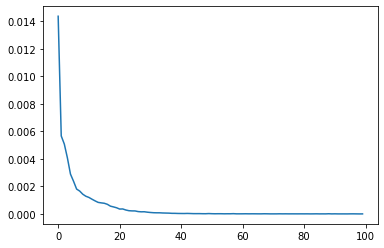

In [9]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq,1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))


# plot_model(model, to_file='C:\DARSHINI\VIT\SEMESTER_8 Winter(23-24)\Research Paper\images\conv_model.png', show_shapes=True, show_layer_names=True, 
#            expand_nested=True, dpi=300, rankdir='TB', 
#            layer_range=None, 
#            show_dtype=False)


print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=100)
plt.plot(history.history['loss'])
plt.show()

16/16 [==============================] - 2s 60ms/step
6.361851053577916


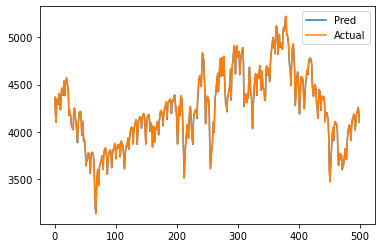

In [10]:
predict_from_model(model, X_test, y_test, scalers['scalerele'])

### CNN-LSTM

In [11]:
n_steps = 360

X_train, y_train = split_sequences(train.values, n_steps)
X_test, y_test = split_sequences(test.values, n_steps)

n_features, n_seq, n_steps = X_train.shape[2], 12, 30

X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 30, 64)     192       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 15, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 960)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                202200    
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                      

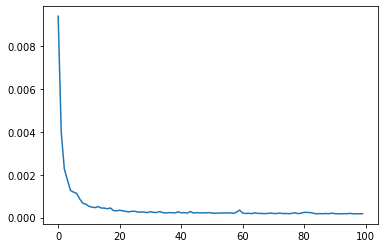

In [12]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))


# plot_model(model, to_file='C:\DARSHINI\VIT\SEMESTER_8 Winter(23-24)\Research Paper\images\cnn_model.png', show_shapes=True, show_layer_names=True, 
#            expand_nested=True, dpi=300, rankdir='TB', 
#            layer_range=None, 
#            show_dtype=False)

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=100)
plt.plot(history.history['loss'])
plt.show()

16/16 [==============================] - 1s 15ms/step
44.62759986355987


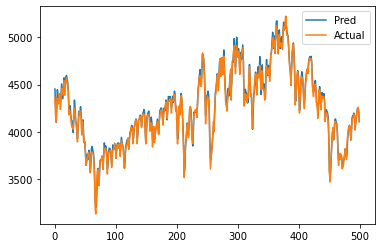

In [13]:
predict_from_model(model, X_test, y_test, scalers['scalerele'])

### Bidirectional LSTM

In [14]:
n_steps = 365

X_train, y_train = split_sequences(train.values, n_steps)
X_test, y_test = split_sequences(test.values, n_steps)

n_features = X_train.shape[2]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              21200     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 21,301
Trainable params: 21,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
96/96 [==============================] - 37s 278ms/step - loss: 0.0255 - root_mean_squared_error: 0.1598
Epoch 2/100
96/96 [==============================] - 27s 279ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486
Epoch 3/100
96/96 [==============================] - 29s 297ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423
Epoch 4/100
96/96 [=====

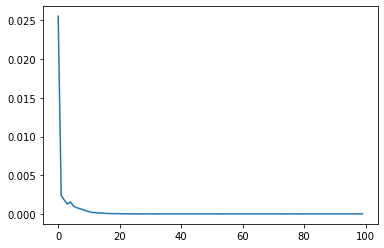

In [15]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))


# plot_model(model, to_file='C:\DARSHINI\VIT\SEMESTER_8 Winter(23-24)\Research Paper\images\dir_model.png', show_shapes=True, show_layer_names=True, 
#            expand_nested=True, dpi=300, rankdir='TB', 
#            layer_range=None, 
#            show_dtype=False)

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=100)
plt.plot(history.history['loss'])
plt.show()

16/16 [==============================] - 1s 45ms/step
2.4993062381766613


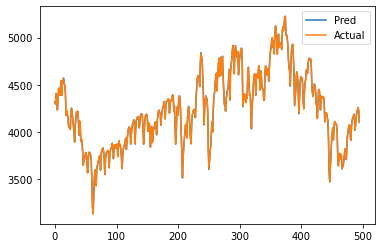

In [16]:
predict_from_model(model, X_test, y_test, scalers['scalerele'])

### LSTM

In [17]:
n_steps = 365

X_train, y_train = split_sequences(train.values, n_steps)
X_test, y_test = split_sequences(test.values, n_steps)

n_features = X_train.shape[2]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 365, 64)           17152     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
96/96 [==============================] - 29s 251ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502
Epoch 2/100
96/96 [==============================] - 24s 252ms/step - loss: 0.0028 - root_mean_squared_error: 0.0526
Epoch 3/100
96/96 [==============================] - 24s 248ms/step - loss:

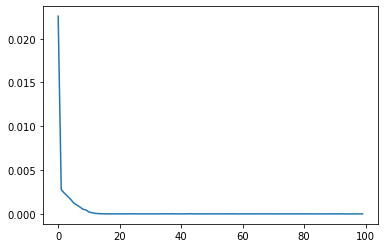

In [18]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(n_steps, n_features)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))


# plot_model(model, to_file='C:\DARSHINI\VIT\SEMESTER_8 Winter(23-24)\Research Paper\images\stacked_model.png', show_shapes=True, show_layer_names=True, 
#            expand_nested=True, dpi=300, rankdir='TB', 
#            layer_range=None, 
#            show_dtype=False)

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=100)
plt.plot(history.history['loss'])
plt.show()

16/16 [==============================] - 2s 86ms/step
4.0887702085922895


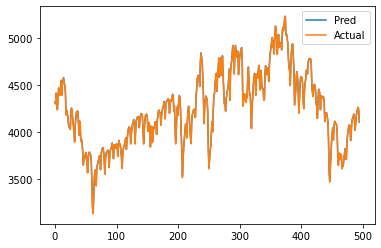

In [19]:
predict_from_model(model, X_test, y_test, scalers['scalerele'])